In [1]:
#| default_exp effective_area
from nbdev import *
%reload_ext autoreload
%autoreload 2

In [2]:
#| include: false
import numpy as np
from nbdev.showdoc import *

In [3]:
#| export
import os
import numpy as np
from astropy.io import fits
from wtlike.config import Config

class EffectiveArea(object):
    """ manage the effective area calculation from a CALDB FITS file

    Must specify either a file_path, or a value for CALDB, or that the CALDB environment varable is set

    """

    def __init__(self,
                 irf: 'IRF to use'= 'P8R2_SOURCE_V6',
                 file_path: 'folder to find the AEFF file'=None,
                 CALDB: 'path to override environment variable'=None,
                 use_phidep:'use azmithual dependence for effective area'=False,
                ):
        """
        """

        #ct0_file,ct1_file = get_irf_file(self.irf,CALDB=self.CALDB)
        if CALDB is None:
            self.CALDB=os.environ.get('CALDB',None)
        assert  (file_path or self.CALDB), 'No path given for effective area'

        if not file_path:
            if os.path.exists(f'{self.CALDB}/data' ):
                self.CALDB+='/data'
            self.file_path =  f'{self.CALDB}/glast/lat/bcf/ea'

        self.aeff_file = os.path.expandvars(f'{file_path}/aeff_{irf}_FB.fits')

        assert os.path.exists(self.aeff_file), f'Effective area file {self.aeff_file} not found'
        ct0_file = ct1_file = self.aeff_file ##cdbm.get_aeff()
        self._read_aeff(ct0_file,ct1_file)
        if use_phidep:
            self._read_phi(ct0_file,ct1_file)

    def _read_file(self,filename,tablename,columns):
        with fits.open(filename) as hdu:
            table = hdu[tablename]
            cbins = np.append(table.data.field('CTHETA_LO')[0],table.data.field('CTHETA_HI')[0][-1])
            ebins = np.append(table.data.field('ENERG_LO')[0],table.data.field('ENERG_HI')[0][-1])
            images = [np.asarray(table.data.field(c)[0],dtype=float).reshape(len(cbins)-1,len(ebins)-1) for c in columns]
        return ebins,cbins,images

    def _read_aeff(self,ct0_file,ct1_file):
        try:
            ebins,cbins,feffarea = self._read_file(ct0_file,'EFFECTIVE AREA',['EFFAREA'])
            ebins,cbins,beffarea = self._read_file(ct1_file,'EFFECTIVE AREA',['EFFAREA'])
        except KeyError:
            ebins,cbins,feffarea = self._read_file(ct0_file,'EFFECTIVE AREA_FRONT',['EFFAREA'])
            ebins,cbins,beffarea = self._read_file(ct1_file,'EFFECTIVE AREA_BACK',['EFFAREA'])
        self.ebins,self.cbins = ebins,cbins
        self.feffarea = feffarea[0]*1e4;self.beffarea = beffarea[0]*1e4
        self.aeff = _InterpTable(np.log10(ebins),cbins)
        self.faeff_aug = self.aeff.augment_data(self.feffarea)
        self.baeff_aug = self.aeff.augment_data(self.beffarea)

    def _read_phi(self,ct0_file,ct1_file):
        try:
            ebins,cbins,fphis = self._read_file(ct0_file,'PHI_DEPENDENCE',['PHIDEP0','PHIDEP1'])
            ebins,cbins,bphis = self._read_file(ct1_file,'PHI_DEPENDENCE',['PHIDEP0','PHIDEP1'])
        except KeyError:
            ebins,cbins,fphis = self._read_file(ct0_file,'PHI_DEPENDENCE_FRONT',['PHIDEP0','PHIDEP1'])
            ebins,cbins,bphis = self._read_file(ct1_file,'PHI_DEPENDENCE_BACK',['PHIDEP0','PHIDEP1'])
        self.fphis = fphis; self.bphis = bphis
        self.phi = _InterpTable(np.log10(ebins),cbins,augment=False)

    def _phi_mod(self,e,c,event_class,phi):
        # assume phi has already been reduced to range 0 to pi/2
        if phi is None: return 1
        tables = self.fphis if event_class==0 else self.bphis
        par0 = self.phi(e,c,tables[0],bilinear=False)
        par1 = self.phi(e,c,tables[1],bilinear=False,reset_indices=False)
        norm = 1. + par0/(1. + par1)
        phi = 2*abs((2./np.pi)*phi - 0.5)
        return (1. + par0*phi**par1)/norm

    def __call__(self,e,c,phi=None,event_class=-1,bilinear=True):
        """ Return bilinear (or nearest-neighbour) interpolation.

            Input:
                e -- bin energy; potentially array
                c -- bin cos(theta); potentially array

            NB -- if e and c are both arrays, they must be of the same
                  size; in other words, no outer product is taken
        """
        #print(f'Eff call: ({e,c})'); #return
        e = np.log10(e)
        at = self.aeff
        if event_class == -1:
            return (at(e,c,self.faeff_aug,bilinear=bilinear)*self._phi_mod(e,c,0,phi),
                    at(e,c,self.baeff_aug,bilinear=bilinear,reset_indices=False)*self._phi_mod(e,c,1,phi))
        elif event_class == 0:
            return at(e,c,self.faeff_aug)*self._phi_mod(e,c,0,phi)
        return at(e,c,self.baeff_aug)*self._phi_mod(e,c,1,phi)

    def get_file_names(self):
        return self.ct0_file,self.ct1_file

    def plots(self, fignum=1):
        """
        """
        import matplotlib.pyplot as plt
        ee = np.logspace(2,6)
        ct = np.linspace(0.2,1)
        plt.rc('font', size=14)
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), num=fignum)

        for et, etname in enumerate('Front Back'.split()):
            ax1.semilogx(ee, [ea(e, 1)[et] for e in ee], '-', lw=2, label=etname)
            ax2.plot(ct, [self(1000,x )[et]/ea(1000,1)[et] for x in ct], '-', lw=2, label=etname)
        ax1.legend()
        ax1.set(xlabel='Energy [Mev]', ylabel='effective area', ylim=(0,None))
        ax1.grid(alpha=0.5)
        ax2.legend()
        ax2.set(xlabel =r'$\cos\ \theta$',ylabel='relative to normal at 1 GeV')
        ax2.grid(alpha=0.5)
        fig.set_facecolor('white')


    def tabulate(self, ctstep=0.05,  logestep=0.25, ctmin=0.4):
        """
        Create a table in bins of front/back, log10e, cos theta

        - ctstep [0.05] step size from ctmin [0.4] to 1
        - logestep [0.25] log10 energy step from 2 (100 MeV) to 6 (1 TeV)
        """

        binvals = lambda a,b,d: np.arange(a+d/2, b, d)

        ctvals = binvals(ctmin, 1.0, ctstep)
        ee = np.power(10, binvals(2,6, logestep))
        A = np.zeros( (2, len(ee), len(ctvals)) )
        for i, ct in enumerate(ctvals):
            f,b =  self(ee, ct)
            A[0,:,i] = f
            A[1,:,i] = b
        return A

class _InterpTable(object):
    """Helper class -- does 2-d interpolation
    """
    def __init__(self,xbins,ybins,augment=True):
        """ Interpolation bins in energy and cos(theta)."""
        self.xbins_0,self.ybins_0 = xbins,ybins
        self.augment = augment
        if augment:
            x0 = xbins[0] - (xbins[1]-xbins[0])/2
            x1 = xbins[-1] + (xbins[-1]-xbins[-2])/2
            y0 = ybins[0] - (ybins[1]-ybins[0])/2
            y1 = ybins[-1] + (ybins[-1]-ybins[-2])/2
            self.xbins = np.concatenate(([x0],xbins,[x1]))
            self.ybins = np.concatenate(([y0],ybins,[y1]))
        else:
            self.xbins = xbins; self.ybins = ybins
        self.xbins_s = (self.xbins[:-1]+self.xbins[1:])/2
        self.ybins_s = (self.ybins[:-1]+self.ybins[1:])/2

    def augment_data(self,data):
        """ Build a copy of data with outer edges replicated."""
        d = np.empty([data.shape[0]+2,data.shape[1]+2])
        d[1:-1,1:-1] = data
        d[0,1:-1] = data[0,:]
        d[1:-1,0] = data[:,0]
        d[-1,1:-1] = data[-1,:]
        d[1:-1,-1] = data[:,-1]
        d[0,0] = data[0,0]
        d[-1,-1] = data[-1,-1]
        d[0,-1] = data[0,-1]
        d[-1,0] = data[-1,0]
        return d

    def set_indices(self,x,y,bilinear=True):
        if bilinear and (not self.augment):
            print('Not equipped for bilinear, going to nearest neighbor.')
            bilinear = False
        self.bilinear = bilinear
        if not bilinear:
            i = np.searchsorted(self.xbins,x)-1
            j = np.searchsorted(self.ybins,y)-1
        else:
            i = np.searchsorted(self.xbins_s,x)-1
            j = np.searchsorted(self.ybins_s,y)-1
        self.indices = i,j

    def value(self,x,y,data):
        i,j = self.indices
        # NB transpose here
        if not self.bilinear: return data[j,i]
        x2,x1 = self.xbins_s[i+1],self.xbins_s[i]
        y2,y1 = self.ybins_s[j+1],self.ybins_s[j]
        f00 = data[j,i]
        f11 = data[j+1,i+1]
        f01 = data[j+1,i]
        f10 = data[j,i+1]
        norm = (x2-x1)*(y2-y1)
        return ( (x2-x)*(f00*(y2-y)+f01*(y-y1)) + (x-x1)*(f10*(y2-y)+f11*(y-y1)) )/norm

    def __call__(self,x,y,data,bilinear=True,reset_indices=True):
        if reset_indices:
            self.set_indices(x,y,bilinear=bilinear)
        return self.value(x,y,data)

In [4]:
show_doc(EffectiveArea.__call__)

<h4 id="EffectiveArea.__call__" class="doc_header"><code>EffectiveArea.__call__</code><a href="__main__.py#L82" class="source_link" style="float:right">[source]</a></h4>

> <code>EffectiveArea.__call__</code>(**`e`**, **`c`**, **`phi`**=*`None`*, **`event_class`**=*`-1`*, **`bilinear`**=*`True`*)

Return bilinear (or nearest-neighbour) interpolation.

Input:
    e -- bin energy; potentially array
    c -- bin cos(theta); potentially array

NB -- if e and c are both arrays, they must be of the same
      size; in other words, no outer product is taken

### Test/demo
Simple creation, evaluation

In [5]:
    def tabulate(self, ctstep=0.05,  logestep=0.25, ctmin=0.4):
        """
        Create a table in bins of front/back, log10e, cos theta

        - ctstep [0.05] step size from ctmin [0.4] to 1
        - logestep [0.25] log10 energy step from 2 (100 MeV) to 6 (1 TeV)
        """

        binvals = lambda a,b,d: np.arange(a+d/2, b, d)
    
        ctvals = binvals(ctmin, 1.0, ctstep)
        ee = np.power(10, binvals(2,6, logestep))
        A = np.zeros( (2, len(ee), len(ctvals)) )
        for i, ct in enumerate(ctvals):
            f,b =  self(ee, ct)
            A[0,:,i] = f
            A[1,:,i] = b
        return A

Create an  EffectiveArea using file at file_path /mnt/c/Users/thbur/onedrive/fermi/wtlike-data/aeff_files
USing file /mnt/c/Users/thbur/onedrive/fermi/wtlike-data/aeff_files/aeff_P8R2_SOURCE_V6_FB.fits:
Values at E=1000, cos(theta)=1 : [4437, 3870]

Test the tabulate function


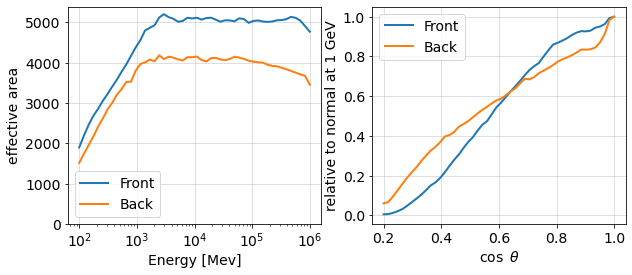

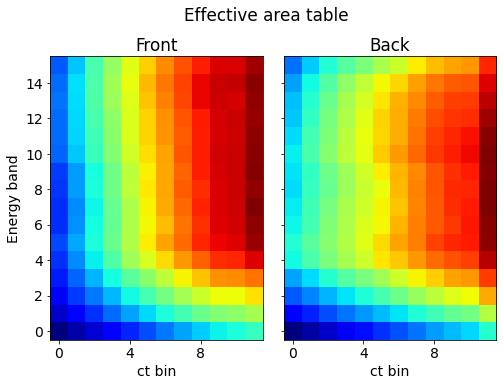

In [6]:
#| include: false
config=Config()

eapath = '' if not config.valid else config.datapath/'aeff_files'
              
if eapath and eapath.is_dir():
    import matplotlib.pyplot as plt
    print(f'Create an  EffectiveArea using file at file_path {eapath}')
    ea = EffectiveArea(file_path=eapath)
    e, ct = 1000, 1
    print(f'USing file {ea.aeff_file}:\nValues at E={e}, cos(theta)={ct} : {list(map(round, ea(e,ct)))}')
    ea.plots()
    print('\nTest the tabulate function')
    
    A = ea.tabulate()
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,6), sharex=True, sharey=True, 
                                  gridspec_kw=dict(top=0.95, wspace=0.1))
    ax1.imshow(A[0], origin='lower', cmap='jet').axes.set(title='Front',ylabel='Energy band', xlabel='ct bin');
    ax2.imshow(A[1], origin='lower', cmap='jet').axes.set(title='Back', xlabel='ct bin', xticks=[0,4,8,])
    
    fig.suptitle('Effective area table');
else:
    print('Not running this test here, since don''t have the file')
    

In [7]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 04_skymaps.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Aug 21 09:54:58 PDT 2022
